# KNN_SVM_프로모션_효율예측분석

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

In [4]:
mem = pd.read_csv("./data/member.csv")
tran = pd.read_csv("./data/transaction.csv")

* 쇼핑몰 고객 데이터, 프로모션 쿠폰을 발행하고 사용 여부 데이터 수집
* mem : 고객id, 최근 방문일, 사는 지역, 추천여부, 주요접속체널, 쿠폰사용여부(target)
* tran : 고객id, 구매수량, 총 구매금액
* 전통적 마케팅 분석 방법 RFM 기법을 활용해 고객 데이터에서 파생변수 생성 후 분석
* R: Recency: 현재일 - 최근 구매일
* F: Frequency: 구매빈도
* M: Monetary: 구매 금액
* 종속변수: conversion => 고객이 프로모션에 반응 했는가? 1 =yes, 0 = no

In [5]:
mem.head(2)

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0


In [6]:
tran.head(5)

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


# 결측값 탐지

In [7]:
mem.isna().sum()

id             0
recency        0
zip_code       0
is_referral    0
channel        0
conversion     0
dtype: int64

In [8]:
tran.isna().sum()

id              0
num_item        0
total_amount    0
dtype: int64

In [9]:
mem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB


In [10]:
tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB


In [11]:
mem.describe()

,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [12]:
tran.describe()

,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


In [13]:
mem.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion'], dtype='object')

In [16]:
mem['id'].nunique()

64000

In [17]:
mem['recency'].value_counts()

recency
1     8952
10    7565
2     7537
9     6441
3     5904
4     5077
6     4605
5     4510
7     4078
11    3504
8     3495
12    2332
Name: count, dtype: int64

In [18]:
mem['zip_code'].value_counts()

zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64

In [20]:
mem['is_referral'].value_counts()

is_referral
1    32144
0    31856
Name: count, dtype: int64

In [21]:
mem['channel'].value_counts()

channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64

In [22]:
mem['conversion'].value_counts()

conversion
0    54606
1     9394
Name: count, dtype: int64

In [24]:
mem.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion'], dtype='object')

tran테이블에서 평균 금액, 빈도

In [27]:
tran

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000
...,...,...,...
196831,536246,5,24000
196832,927617,5,26000
196833,927617,3,22000
196834,927617,3,18000


In [32]:
mean_item_amount = tran.groupby('id')[['num_item','total_amount']].mean()
mean_item_amount = mean_item_amount.reset_index()
mean_item_amount.columns = ['id', 'mean_num_item', 'mean_total_amount']
mean_item_amount

,id,mean_num_item,mean_total_amount
0,100001,3.500000,26000.000000
1,100008,5.000000,26000.000000
2,100032,2.666667,20666.666667
3,100036,3.000000,25800.000000
4,100070,3.250000,21250.000000
...,...,...,...
63995,999932,5.000000,32000.000000
63996,999981,2.000000,22750.000000
63997,999990,3.000000,28000.000000
63998,999995,2.000000,27000.000000


In [36]:
freq = tran.groupby('id')[['id']].count()
freq

,id
id,
100001,2
100008,1
100032,3
100036,5
100070,4
...,...
999932,1
999981,4
999990,3


In [38]:
mean_item_amount = mean_item_amount.set_index('id')
mean_item_amount

,mean_num_item,mean_total_amount
id,,
100001,3.500000,26000.000000
100008,5.000000,26000.000000
100032,2.666667,20666.666667
100036,3.000000,25800.000000
100070,3.250000,21250.000000
...,...,...
999932,5.000000,32000.000000
999981,2.000000,22750.000000
999990,3.000000,28000.000000


In [41]:
mean_item_amount = mean_item_amount.join(freq)
mean_item_amount

,mean_num_item,mean_total_amount,id
id,,,
100001,3.500000,26000.000000,2
100008,5.000000,26000.000000,1
100032,2.666667,20666.666667,3
100036,3.000000,25800.000000,5
100070,3.250000,21250.000000,4
...,...,...,...
999932,5.000000,32000.000000,1
999981,2.000000,22750.000000,4
999990,3.000000,28000.000000,3


In [43]:
mean_item_amount = mean_item_amount.rename(columns={'id':'frequency'})
mean_item_amount

,mean_num_item,mean_total_amount,frequency
id,,,
100001,3.500000,26000.000000,2
100008,5.000000,26000.000000,1
100032,2.666667,20666.666667,3
100036,3.000000,25800.000000,5
100070,3.250000,21250.000000,4
...,...,...,...
999932,5.000000,32000.000000,1
999981,2.000000,22750.000000,4
999990,3.000000,28000.000000,3


총구매 개수, 총 금액 추가

In [46]:
total_num_amount = tran.groupby('id')[['num_item', 'total_amount']].sum()
total_num_amount

,num_item,total_amount
id,,
100001,7,52000
100008,5,26000
100032,8,62000
100036,15,129000
100070,13,85000
...,...,...
999932,5,32000
999981,8,91000
999990,9,84000


In [48]:
mean_item_amount = mean_item_amount.join(total_num_amount)
mean_item_amount

,mean_num_item,mean_total_amount,frequency,num_item,total_amount
id,,,,,
100001,3.500000,26000.000000,2,7,52000
100008,5.000000,26000.000000,1,5,26000
100032,2.666667,20666.666667,3,8,62000
100036,3.000000,25800.000000,5,15,129000
100070,3.250000,21250.000000,4,13,85000
...,...,...,...,...,...
999932,5.000000,32000.000000,1,5,32000
999981,2.000000,22750.000000,4,8,91000
999990,3.000000,28000.000000,3,9,84000


In [51]:
mean_item_amount = mean_item_amount.reset_index()
mean_item_amount

,id,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,100001,3.500000,26000.000000,2,7,52000
1,100008,5.000000,26000.000000,1,5,26000
2,100032,2.666667,20666.666667,3,8,62000
3,100036,3.000000,25800.000000,5,15,129000
4,100070,3.250000,21250.000000,4,13,85000
...,...,...,...,...,...,...
63995,999932,5.000000,32000.000000,1,5,32000
63996,999981,2.000000,22750.000000,4,8,91000
63997,999990,3.000000,28000.000000,3,9,84000
63998,999995,2.000000,27000.000000,1,2,27000


회원정보 테이블과 구매갯수, 금액등을 그룹연산한 mean_item_amount 합치기

In [53]:
data = pd.merge(mem, mean_item_amount, how='left', on='id')
data

,id,recency,zip_code,is_referral,channel,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,906145,10,Surburban,0,Phone,0,3.333333,31333.333333,3,10,94000
1,184478,6,Rural,1,Web,0,4.000000,29000.000000,1,4,29000
2,394235,7,Surburban,1,Web,0,4.000000,20500.000000,2,8,41000
3,130152,9,Rural,1,Web,0,1.750000,20750.000000,4,7,83000
4,940352,2,Urban,0,Web,0,3.000000,31000.000000,1,3,31000
...,...,...,...,...,...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0,3.500000,26000.000000,4,14,104000
63996,547316,5,Urban,1,Phone,0,1.800000,17800.000000,5,9,89000
63997,131575,6,Urban,1,Phone,0,4.000000,30500.000000,2,8,61000
63998,603659,1,Surburban,1,Multichannel,0,3.200000,21600.000000,5,16,108000


In [55]:
data.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion',
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount'],
      dtype='object')

<Axes: ylabel='Frequency'>

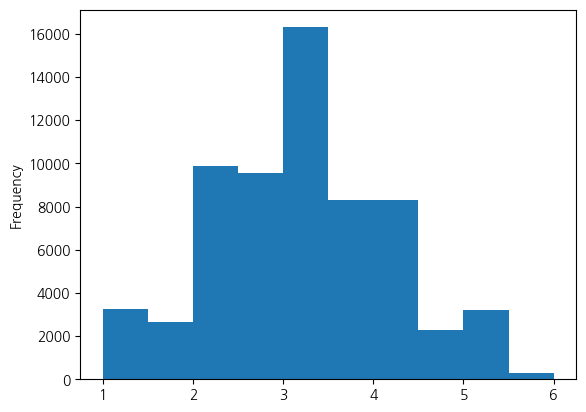

In [56]:
data['mean_num_item'].plot(kind='hist')

<Axes: ylabel='Frequency'>

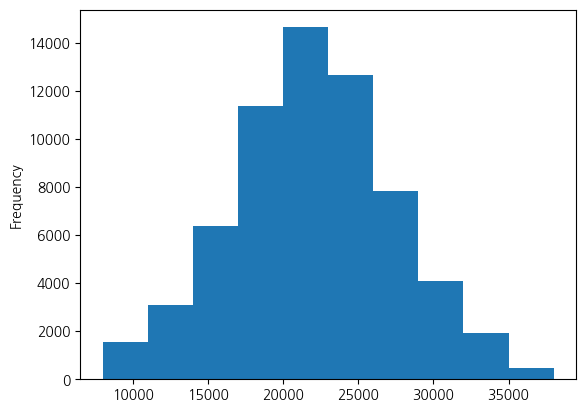

In [57]:
data['mean_total_amount'].plot(kind='hist')

<Axes: ylabel='Frequency'>

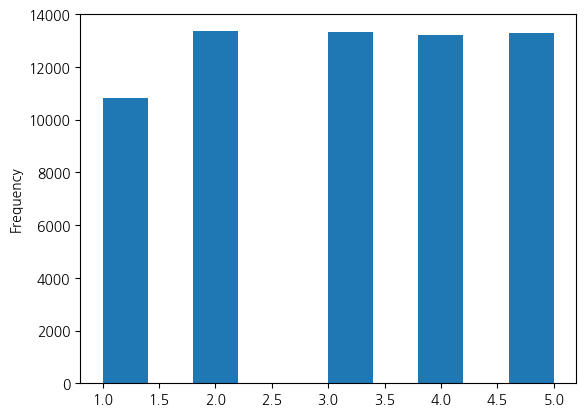

In [58]:
data['frequency'].plot(kind='hist')

<Axes: ylabel='Frequency'>

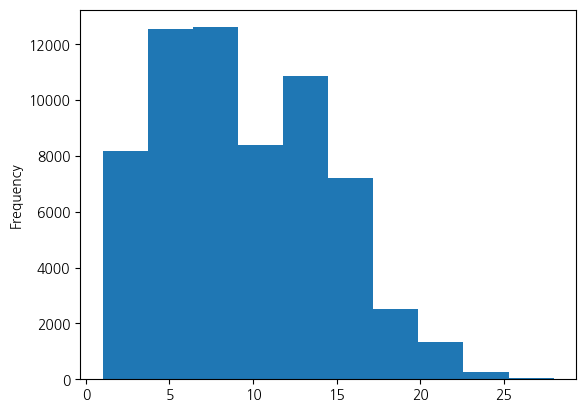

In [59]:
data['num_item'].plot(kind='hist')

<Axes: ylabel='Frequency'>

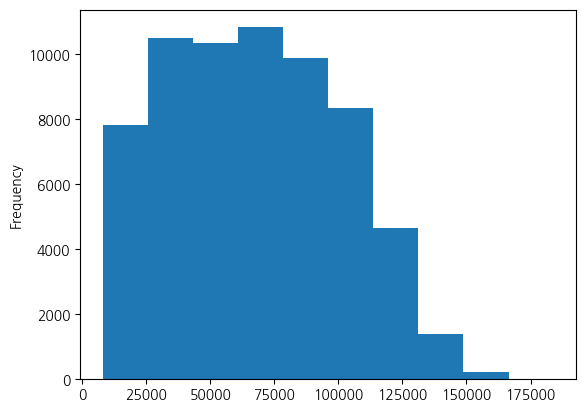

In [60]:
data['total_amount'].plot(kind='hist')

In [61]:
data.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion',
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount'],
      dtype='object')

In [62]:
col_names = ['recency', 'zip_code', 'is_referral', 'channel', 
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount']

In [64]:
for col in col_names:
    print("="*30, col, "="*30)
    print(data.groupby(col)['conversion'].mean().sort_values(ascending=False))
    print()

============================== recency ==============================
recency
1     0.193029
2     0.177790
3     0.166328
4     0.148907
5     0.142350
6     0.140717
7     0.133889
8     0.127897
12    0.126930
11    0.120719
9     0.113957
10    0.112624
Name: conversion, dtype: float64

============================== zip_code ==============================
zip_code
Rural        0.188121
Surburban    0.139943
Urban        0.139044
Name: conversion, dtype: float64

============================== is_referral ==============================
is_referral
0    0.173060
1    0.120738
Name: conversion, dtype: float64

============================== channel ==============================
channel
Multichannel    0.171734
Web             0.159407
Phone           0.127155
Name: conversion, dtype: float64

============================== mean_num_item ==============================
mean_num_item
5.333333    1.000000
5.250000    1.000000
6.000000    1.000000
5.750000    1.000000
5.666667    1.00000

In [65]:
data

,id,recency,zip_code,is_referral,channel,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,906145,10,Surburban,0,Phone,0,3.333333,31333.333333,3,10,94000
1,184478,6,Rural,1,Web,0,4.000000,29000.000000,1,4,29000
2,394235,7,Surburban,1,Web,0,4.000000,20500.000000,2,8,41000
3,130152,9,Rural,1,Web,0,1.750000,20750.000000,4,7,83000
4,940352,2,Urban,0,Web,0,3.000000,31000.000000,1,3,31000
...,...,...,...,...,...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0,3.500000,26000.000000,4,14,104000
63996,547316,5,Urban,1,Phone,0,1.800000,17800.000000,5,9,89000
63997,131575,6,Urban,1,Phone,0,4.000000,30500.000000,2,8,61000
63998,603659,1,Surburban,1,Multichannel,0,3.200000,21600.000000,5,16,108000


# 거리기반의 알고리즘을 사용시 독립변수들 간의 단위를 꼭 맞춰 주어야 함
# 스케일링
* MinMaxScaler: 모든 숫자를 0-1사이의 숫자로 변환 - 데이터 분포의 모양을 그대로 유지
* StandardScaler: 평균을 0, 표준편차를 1로 하는 정규분포 형태로 변환 - 데이터의 분포 모양이 정규 분포로 바뀜
* RobustScaler: 사분위수를 이용해서 데이터를 스케일링 - 데이터에 이상값이 있을 때 사용, 이상값에 영향을 최소화

# 머신러닝 모델별 스케일러
* knn(최근접이웃): MinMaxScaler, 이상치가 있는 경우 RobustScaler
* SVM(서포트 벡터 머신): StandardScaler, 이상치가 있는 경우 RobustScaler
* Logistic Regression: StandardScaler, 이상치가 있는 경우 RobustScaler
* Linear / Ridge / Lasso: StandardScaler, 이상치가 있는 경우 RobustScaler
* KMeans / DBSCAN: MinMax or StandardScaler, 이상치가 있는 경우 RobustScaler
* DecisionTree, RandomForest, XGBoost: 스케일링 불필요, 이상치가 있는 경우에도 안해도 됨
* Naive Bayes: 스케일링 불필요, 이상치가 있는 경우에도 안해도 됨
* 인공신경망: MinMax or StandardScaler, 이상치가 있는 경우 RobustScaler

# 스케일링 시점: train /test로 나눈 후에  실시

In [66]:
data

,id,recency,zip_code,is_referral,channel,conversion,mean_num_item,mean_total_amount,frequency,num_item,total_amount
0,906145,10,Surburban,0,Phone,0,3.333333,31333.333333,3,10,94000
1,184478,6,Rural,1,Web,0,4.000000,29000.000000,1,4,29000
2,394235,7,Surburban,1,Web,0,4.000000,20500.000000,2,8,41000
3,130152,9,Rural,1,Web,0,1.750000,20750.000000,4,7,83000
4,940352,2,Urban,0,Web,0,3.000000,31000.000000,1,3,31000
...,...,...,...,...,...,...,...,...,...,...,...
63995,838295,10,Urban,0,Web,0,3.500000,26000.000000,4,14,104000
63996,547316,5,Urban,1,Phone,0,1.800000,17800.000000,5,9,89000
63997,131575,6,Urban,1,Phone,0,4.000000,30500.000000,2,8,61000
63998,603659,1,Surburban,1,Multichannel,0,3.200000,21600.000000,5,16,108000


카테고리 변수를 one-hot encoding

In [67]:
data.columns

Index(['id', 'recency', 'zip_code', 'is_referral', 'channel', 'conversion',
       'mean_num_item', 'mean_total_amount', 'frequency', 'num_item',
       'total_amount'],
      dtype='object')

In [69]:
data = pd.get_dummies(data, columns=['zip_code', 'channel'], drop_first=True)

홀드 아웃

In [83]:
X = data.drop(['id', 'conversion'], axis=1)
y = data['conversion']

In [84]:
X

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,10,0,3.333333,31333.333333,3,10,94000,True,False,True,False
1,6,1,4.000000,29000.000000,1,4,29000,False,False,False,True
2,7,1,4.000000,20500.000000,2,8,41000,True,False,False,True
3,9,1,1.750000,20750.000000,4,7,83000,False,False,False,True
4,2,0,3.000000,31000.000000,1,3,31000,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...
63995,10,0,3.500000,26000.000000,4,14,104000,False,True,False,True
63996,5,1,1.800000,17800.000000,5,9,89000,False,True,True,False
63997,6,1,4.000000,30500.000000,2,8,61000,False,True,True,False
63998,1,1,3.200000,21600.000000,5,16,108000,True,False,False,False


In [85]:
y.value_counts()

conversion
0    54606
1     9394
Name: count, dtype: int64

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, stratify=y_valid, random_state=42)

# 데이터 단위를 맞추기 위해서 scaling

In [88]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [89]:
mms = MinMaxScaler()
mms.fit(X_train)
mms_X_train = mms.transform(X_train)
mms_X_valid = mms.transform(X_valid)
mms_X_test = mms.transform(X_test)

In [93]:
mms_X_train = pd.DataFrame(mms_X_train, columns=X_train.columns)
mms_X_valid = pd.DataFrame(mms_X_valid, columns=X_train.columns)
mms_X_test = pd.DataFrame(mms_X_test, columns=X_train.columns)

In [90]:
X_test

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
15576,12,1,5.000000,23000.0,1,5,23000,True,False,True,False
24159,4,1,2.333333,21000.0,3,7,63000,True,False,True,False
11135,2,1,2.500000,30500.0,2,5,61000,False,True,True,False
46485,5,0,2.250000,22000.0,4,9,88000,True,False,True,False
27143,6,1,2.500000,16250.0,4,10,65000,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
54788,11,1,4.000000,16600.0,5,20,83000,True,False,False,True
12199,4,0,2.000000,21600.0,5,10,108000,True,False,False,True
23992,4,0,2.800000,29800.0,5,14,149000,False,True,True,False
59787,7,1,4.200000,27400.0,5,21,137000,False,True,True,False


In [94]:
mms_X_test

,recency,is_referral,mean_num_item,mean_total_amount,frequency,num_item,total_amount,zip_code_Surburban,zip_code_Urban,channel_Phone,channel_Web
0,1.000000,1.0,0.800000,0.500000,0.00,0.148148,0.085227,1.0,0.0,1.0,0.0
1,0.272727,1.0,0.266667,0.433333,0.50,0.222222,0.312500,1.0,0.0,1.0,0.0
2,0.090909,1.0,0.300000,0.750000,0.25,0.148148,0.301136,0.0,1.0,1.0,0.0
3,0.363636,0.0,0.250000,0.466667,0.75,0.296296,0.454545,1.0,0.0,1.0,0.0
4,0.454545,1.0,0.300000,0.275000,0.75,0.333333,0.323864,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
12795,0.909091,1.0,0.600000,0.286667,1.00,0.703704,0.426136,1.0,0.0,0.0,1.0
12796,0.272727,0.0,0.200000,0.453333,1.00,0.333333,0.568182,1.0,0.0,0.0,1.0
12797,0.272727,0.0,0.360000,0.726667,1.00,0.481481,0.801136,0.0,1.0,1.0,0.0
12798,0.545455,1.0,0.640000,0.646667,1.00,0.740741,0.732955,0.0,1.0,1.0,0.0


# KNN(K-Nearest Neighbor)

In [95]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [96]:
knn = KNeighborsClassifier(n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     10921
           1       0.39      0.14      0.21      1879

    accuracy                           0.84     12800
   macro avg       0.63      0.55      0.56     12800
weighted avg       0.80      0.84      0.81     12800



# KNN의 하이퍼파라미터 튜닝
* n_neighbors= ? 
* 전체 샘플수가 적을 때 10000개 이하일 때 3, 5, 7 같은 홀수 값
* 전체 샘플수가 10000개 초과시 루트(n), log2(n)

In [97]:
len(mms_X_train)

38400

# 최적K는?

In [98]:
# 루트를 이용한 최적 K 계산
n = len(mms_X_train)
print(n)
k = int(np.sqrt(n))
print(np.sqrt(n), k)

38400
195.95917942265424 195


In [99]:
# log2(n)을 이용한 최적 k 계산
n = len(mms_X_train)
k_log2 = int(np.log2(n))
print(k_log2)

15


In [100]:
# 루트를 이용해 계산한 k 값 195 적용
knn = KNeighborsClassifier(n_neighbors=195, n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [101]:
# log2(n)를 이용해 계산한 k 값 15 적용
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
knn.fit(mms_X_train, y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10921
           1       0.59      0.07      0.13      1879

    accuracy                           0.86     12800
   macro avg       0.73      0.53      0.52     12800
weighted avg       0.82      0.86      0.81     12800



In [102]:
y.value_counts()

conversion
0    54606
1     9394
Name: count, dtype: int64

데이터 증폭을 통한 성능 개선

In [104]:
mms_X_train.columns

Index(['recency', 'is_referral', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [103]:
from imblearn.over_sampling import SMOTENC

In [105]:
smtnc = SMOTENC(categorical_features=[1, 7, 8, 9, 10], random_state=42)
smt_X_train, smt_y_train = smtnc.fit_resample(mms_X_train, y_train)

C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [106]:
smt_y_train.value_counts()

conversion
0    32764
1    32764
Name: count, dtype: int64

In [108]:
len(smt_X_train)

65528

In [107]:
n = len(smt_X_train)
k_log2 = int(np.log2(n))
print(k_log2)

15


In [110]:
# log2(n)를 이용해 계산한 k 값 15 적용
knn = KNeighborsClassifier(n_neighbors=15, n_jobs=8)
knn.fit(smt_X_train, smt_y_train)
valid_pred = knn.predict(mms_X_valid)
print(classification_report(y_valid, valid_pred))
print("========= Test Result=========")
test_pred = knn.predict(X_test)
print(classification_report(y_test, test_pred))


              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.60      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800



C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [111]:
# log2(n)를 이용해 계산한 k 값 15 적용
for i in range(3, 22, 2):
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=8)
    knn.fit(smt_X_train, smt_y_train)
    valid_pred = knn.predict(mms_X_valid)
    print(classification_report(y_valid, valid_pred))
    print(f"========= Test Result {i}=========")
    test_pred = knn.predict(X_test)
    print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81     10921
           1       0.23      0.44      0.30      1879

    accuracy                           0.71     12800
   macro avg       0.56      0.60      0.56     12800
weighted avg       0.79      0.71      0.74     12800

========= Test Result 3=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.89      0.72      0.80     10921
           1       0.23      0.49      0.32      1879

    accuracy                           0.69     12800
   macro avg       0.56      0.61      0.56     12800
weighted avg       0.79      0.69      0.73     12800

========= Test Result 5=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.90      0.70      0.78     10921
           1       0.23      0.53      0.32      1879

    accuracy                           0.67     12800
   macro avg       0.56      0.61      0.55     12800
weighted avg       0.80      0.67      0.72     12800

========= Test Result 7=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.90      0.69      0.78     10921
           1       0.23      0.56      0.33      1879

    accuracy                           0.67     12800
   macro avg       0.57      0.62      0.55     12800
weighted avg       0.80      0.67      0.71     12800

========= Test Result 9=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.90      0.68      0.78     10921
           1       0.24      0.57      0.33      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.63      0.56     12800
weighted avg       0.80      0.66      0.71     12800

========= Test Result 11=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.91      0.68      0.77     10921
           1       0.24      0.59      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.63      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 13=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.60      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 15=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.61      0.34      1879

    accuracy                           0.66     12800
   macro avg       0.57      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 17=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     10921
           1       0.24      0.62      0.35      1879

    accuracy                           0.66     12800
   macro avg       0.58      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 19=========


C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800

              precision    recall  f1-score   support

           0       0.91      0.66      0.77     10921
           1       0.24      0.62      0.35      1879

    accuracy                           0.66     12800
   macro avg       0.58      0.64      0.56     12800
weighted avg       0.81      0.66      0.71     12800

========= Test Result 21=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0

C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [112]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight="balanced", n_jobs=8, random_state=42)
rfc.fit(smt_X_train, smt_y_train)
valid_pred = rfc.predict(mms_X_valid)
print("========= Valid Result=========")
print(classification_report(y_valid, valid_pred))
print("========= Test Result=========")
test_pred = rfc.predict(X_test)
print(classification_report(y_test, test_pred))
print()

========= Valid Result=========
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     10921
           1       0.35      0.30      0.32      1879

    accuracy                           0.82     12800
   macro avg       0.62      0.60      0.61     12800
weighted avg       0.80      0.82      0.81     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10921
           1       0.15      1.00      0.26      1879

    accuracy                           0.15     12800
   macro avg       0.07      0.50      0.13     12800
weighted avg       0.02      0.15      0.04     12800




C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\haram\miniforge3\envs\fintech\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

# 서포트 벡터 SVC를 사용해서 분석
* StandardScaler
* 카테고리 변수를 제외하고 StandardScaler를 사용하는 것이 좋음

In [114]:
from sklearn.preprocessing import StandardScaler

In [115]:
X_train.columns

Index(['recency', 'is_referral', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web'],
      dtype='object')

In [116]:
X_train_cat = X_train[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_train_num = X_train[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]
X_valid_cat = X_valid[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_valid_num = X_valid[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]
X_test_cat = X_test[['is_referral', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Phone', 'channel_Web']]
X_test_num = X_test[['recency', 'mean_num_item', 'mean_total_amount',
       'frequency', 'num_item', 'total_amount']]

In [117]:
X_train_num.columns

Index(['recency', 'mean_num_item', 'mean_total_amount', 'frequency',
       'num_item', 'total_amount'],
      dtype='object')

In [118]:
num_cols = X_train_num.columns

In [119]:
X_valid[num_cols]

,recency,mean_num_item,mean_total_amount,frequency,num_item,total_amount
61161,5,3.750000,22250.000000,4,15,89000
55598,9,2.333333,22333.333333,3,7,67000
25013,3,1.000000,15000.000000,1,1,15000
19407,10,5.000000,14000.000000,1,5,14000
30427,2,2.800000,15800.000000,5,14,79000
...,...,...,...,...,...,...
53675,4,4.500000,19000.000000,2,9,38000
54661,11,2.000000,9000.000000,1,2,9000
36640,11,3.200000,22600.000000,5,16,113000
30738,6,3.500000,24000.000000,4,14,96000


In [120]:
ss = StandardScaler()
ss.fit(X_train_num)
X_train_num_temp = ss.transform(X_train_num)
X_valid_num_temp = ss.transform(X_valid[num_cols])
X_test_num_temp = ss.transform(X_test[num_cols])

In [123]:
# pd.DataFrame(X_train_num_temp, columns=num_cols)

In [128]:
X_train_num.index

Index([11734, 43876, 34934, 30562, 32242, 44194, 10988, 32324,  3065, 24950,
       ...
       45360, 27982,  2420,  3126, 56832, 44666, 29962,  4734,  3437, 27103],
      dtype='int64', length=38400)

In [129]:
ss_X_train_num = pd.DataFrame(X_train_num_temp, columns=num_cols, index=X_train_num.index)
ss_X_valid_num = pd.DataFrame(X_valid_num_temp, columns=num_cols, index=X_valid.index)
ss_X_test_num = pd.DataFrame(X_test_num_temp, columns=num_cols, index=X_test.index)

In [131]:
X_train_cat.columns

Index(['is_referral', 'zip_code_Surburban', 'zip_code_Urban', 'channel_Phone',
       'channel_Web'],
      dtype='object')

In [138]:
cat_cols = X_train_cat.columns

In [135]:
# pd.concat([ss_X_train_num, X_train_cat], axis=1)

In [136]:
ss_X_train = pd.concat([ss_X_train_num, X_train_cat], axis=1)

In [141]:
ss_X_valid = pd.concat([ss_X_valid_num, X_valid[cat_cols]], axis=1)
ss_X_test = pd.concat([ss_X_test_num, X_test[cat_cols]], axis=1)

In [142]:
from sklearn.svm import SVC

In [143]:
svc = SVC()
svc.fit(ss_X_train, y_train)
valid_pred = svc.predict(ss_X_valid)
print("========= Valid Result=========")
print(classification_report(y_valid, valid_pred))
print("========= Test Result=========")
test_pred = svc.predict(ss_X_test)
print(classification_report(y_test, test_pred))
print()

========= Valid Result=========
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     10921
           1       0.79      0.08      0.15      1879

    accuracy                           0.86     12800
   macro avg       0.83      0.54      0.54     12800
weighted avg       0.85      0.86      0.81     12800

========= Test Result=========
              precision    recall  f1-score   support

           0       0.86      1.00      0.93     10921
           1       0.85      0.08      0.15      1879

    accuracy                           0.86     12800
   macro avg       0.86      0.54      0.54     12800
weighted avg       0.86      0.86      0.81     12800


